<div style="font-size: 60px; font-weight:bold; margin:20px; margin-bottom:100px; text-align: justify; text-shadow: 1px 1px 1px #919191,
        1px 2px 1px #919191,
        1px 3px 1px #919191,
        1px 4px 1px #919191,
        1px 5px 1px #919191,
        1px 6px 1px #919191,
        1px 7px 1px #919191,
        1px 8px 1px #919191,
        1px 9px 1px #919191,
        1px 10px 1px #919191,
    1px 18px 6px rgba(16,16,16,0.4),
    1px 22px 10px rgba(16,16,16,0.2),
    1px 25px 35px rgba(16,16,16,0.2),
    1px 30px 60px rgba(16,16,16,0.4)"> INTRODUCTION TO SPARK </div>
    <div style="font-style: italic; font-weight: bold; font-size:35px; text-align:center; font-family: Garamond">by Rubén Cañadas Rodríguez</div>
    
<div style="font-size: 30px; margin: 20px; margin-bottom: 40px; margin-left: 0px; line-height: 40pt">

<div style="font-size: 30px; font-family: Garamond; font-weight: bold; margin: 30px; margin-left: 0px; margin-bottom: 10px; ">Contents</div>
<ol>
<li>Introduction</li>
<li>Spark</li>
<li>SparkSQL</li> 
<li>MMLIB</li> 
</ol>
</div>


<div style="font-size: 30px; font-weight: bold; margin-bottom: 20px; margin-top: 30px"> Introduction </div>
<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
Spark is a fast and general engine for large-scale data preprocessing. It can be used on the HDFS (Hadoop Distributed FileSystem) or others such as the S3 filesystem from Amazon. Its structure allows it to be highly scalable. It is 100X faster thatn Hadoop MapReduce in memory and 10X faster in disk. This is due to the DAG engine (Directed Acyclic Graph). It constructs a graph and computes the most optimal way to give the desired results. All this allows to perform several actions in huge datasets using distributed computing, for example, data processing, machine learning or graph-based methods. This is an introductory tutorial of Spark. The intention is to give the user a basic knowledge of the core parts of Spark and how to perform several transformations and actions. Also, MMLIB will be used which is a machine learning framework built upon the core Spark. Thanks to this, machine learning can be used in a high efficiency way with enormouse and distributed datasets.
</div>
<div style="font-size: 30px; font-weight: bold; margin-bottom: 20px; margin-top: 30px"> Spark </div>
<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
Spark uses RDD (Resilient Distributed Dataset) objects to perform all its magic. RDDs can be thought as those objects containing the datasets giving some important properties: Resilience which means that if for any reason a node goes down it can be recovered from failure. Also, it is distributed meaning that distributed data in HDFS, S3 or others can be used and actions are carried out in a distributed way. In this introductory tutorial of Spark we will give
some examples of how Spark can be utilized. For this propose we will be using pyspark from Python. However, 
in more advanced tutorials, Scala, which is its native lanaguage will be used, since it gives much better performance and it is really really important in Big Data since we work with huge datasets!<br>
Let us first start by importing packages and modules (do not worry about the hide_toggle funtion, it is only for
hidding the exercises proposed):

</div>


In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import lit
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
%matplotlib inline

"""
INFO: pyspark works with java 8 so export it before running the notebook
export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)
you can added it on ~/.bashrc
"""
print("Using pyspark version: {}".format(pyspark.__version__))


Using pyspark version: 2.4.3


<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
Before starting to work with datasets we need to create a Context and the RDD object. The Context is what allows the driver program to acces to the cluster manager (Spark, YARN, Mesos...) and the executors. In the following figure an overall idea of this is given:
    
<img src="spark_conf.png" width="800" style="padding: 15px">

The config object saves the configuration (name of the app running and where it has to be executed) given to the Context. If once the context is running, if another has to be created, the former has to be stopped: sc.stop()<br>
Now let us work a play a little bit wirh RDDs. First of all, we need to download some dataset, for instance the
<a target="_blank" href="https://grouplens.org/datasets/movielens/" style="text-decoration: none">MovieLens</a> dataset. 
    
</div>

final  [('1', 4), ('10', 4), ('100', 5), ('1000', 3), ('1001', 2)]
results  [('1', ('Toy Story (1995)', 4)), ('4', ('Get Shorty (1995)', 4)), ('8', ('Babe (1995)', 4)), ('9', ('Dead Man Walking (1995)', 4)), ('10', ('Richard III (1995)', 4))]


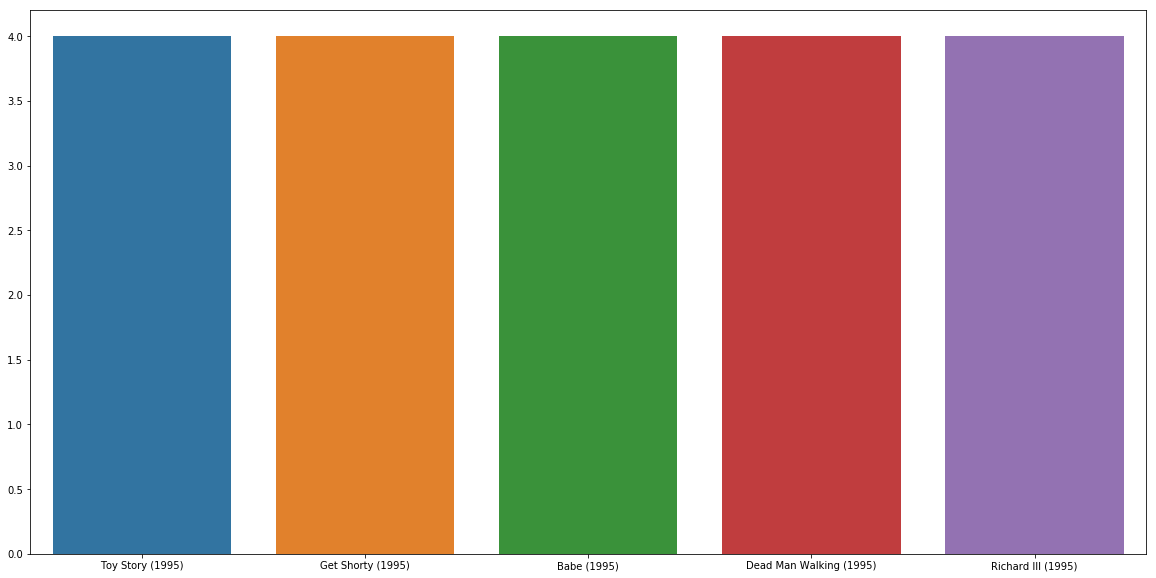

In [3]:

sc.stop()
config = SparkConf().setAppName("spark_app").setMaster("local")
sc = SparkContext(conf=config)
file_name = "ml-100k/u.data"
parsed = sc.textFile(file_name).map(lambda x: (x.split("\t"))).map(lambda x: (x[1], x[2])) # (movieID, rating) tuple
rdd = parsed.mapValues(lambda x: (int(x), 1)).sortByKey()
reduc = rdd.reduceByKey(lambda a, b : (a[0]+b[0], a[1]+b[1])).sortByKey() # a is the first value and b the second value
final = reduc.mapValues(lambda a: int(np.ceil(a[0] / a[1]))) #Computing averages
print("final ", final.take(5)) #Nothing happens until doing action take, only DAG is drawn

#We know the movieID, but what about the name?? Let's match movieID with its name using the u.item file!

def load_movie_names():
    movie_names = []
    infile = open("ml-100k/u.item", "r", encoding="utf8", errors="ignore")
    for line in infile:
        fields = line.split("|")
        movie_names.append((fields[0], fields[1]))
    return movie_names

rdd_names = sc.parallelize(load_movie_names()) #Creating a RDD from list using parallelize method!
joined = rdd_names.join(final)
print("results ", joined.take(5))

#Once we have joined them and we have the tables let us plot the results using our favorite plotting library!
names = []
rating = []
for elem in joined.collect(): #collect allows to make the RDD iterable!
    names.append(elem[1][0])
    rating.append(elem[1][1])
plt.figure(figsize=(20,10)) #size of the figure!
sns.barplot(names[:5], rating[:5]) #Only the first five since there is lots of information!
plt.show()


<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
    <strong>NOW IT IS YOUR TURN! </strong>I propose a similar exercise in order to test yourself. What if we wanted to know the average ratings per each job? Each user has a job in the u.user file, and the question is if depending on the job the ratings change. Sort the results by the job name! <strong>GOOD LUCK!</strong> To check the answer press the show button below.
</div>

jobs  [('administrator', 4), ('artist', 4), ('doctor', 4), ('educator', 4), ('engineer', 4), ('entertainment', 4), ('executive', 4), ('healthcare', 3), ('homemaker', 4), ('lawyer', 4), ('librarian', 4), ('marketing', 4), ('none', 4), ('other', 4), ('programmer', 4), ('retired', 4), ('salesman', 4), ('scientist', 4), ('student', 4), ('technician', 4), ('writer', 4)]


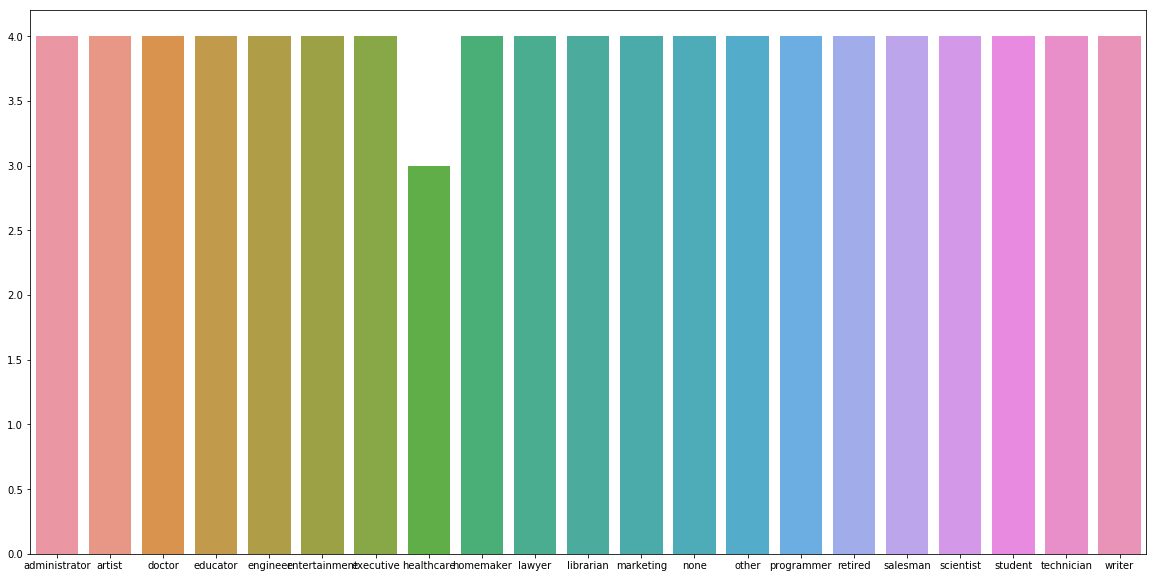

In [4]:
"""SOLUTION TO THE PROPOSED EXERCISE!"""

sc.stop()
config = SparkConf().setAppName("spark_app").setMaster("local")
sc = SparkContext(conf=config)
file_name = "ml-100k/u.data"
parsed = sc.textFile(file_name).map(lambda x: (x.split("\t"))).map(lambda x: (x[0], x[2])) # (userID, rating)
#rdd = parsed.mapValues(lambda x: (int(x), 1))
#average = rdd.mapValues(lambda x: int(np.ceil(x[0] / float(x[1]))))
#print("rdd ", average.take(4))

def load_user_names():
    movie_names = []
    infile = open("ml-100k/u.user", "r", encoding="utf8", errors="ignore")
    for line in infile:
        fields = line.split("|")
        movie_names.append((fields[0], fields[3])) #(userID, ocupation)
    return movie_names

rdd_names = sc.parallelize(load_user_names())
joined = rdd_names.join(parsed)

jobs = joined.map(lambda x: (x[1][0], x[1][1])).mapValues(lambda x: (int(x),1)).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
average = jobs.mapValues(lambda x: int(np.ceil(x[0]/x[1]))).sortByKey()
print("jobs ", average.take(21))
jobs = []
rating = []
for elem in average.collect(): #collect allows to make the RDD iterable!
    jobs.append(elem[0])
    rating.append(elem[1])
plt.figure(figsize=(20,10)) #size of the figure!
sns.barplot(jobs[:21], rating[:21]) #Only the first five since there is lots of information!
plt.show()


<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
So far we have seen how to create RDDs from files and how to use transformations and actions on RDDs in order to obtain informative results out of a dataset, in this case from movies. From Spark 2.0 there is an option that is to create dataframes which are built upon RDDs. Using this dataframes we can apply several methods on them. Later, we will see how we can use SQL queries in order to make data analysis even easier! <br>
In this case we create a Spark Session which will automatically create the Context. The getOrCreate() methods allows to recover the RDDs that have failed due to problems in nodes. Then we parse the file and create the dataframe. The cache() method is called in order not to create the dataframe over and over again. Once the dataframe has been created several methods such as filter, count, select or map can be applied to it. In RDDs we use the take() action in order to compute the most optimal path in the graph and show the results. In dataframes, to check the results we use the show() method.
</div>

In [ ]:

file_name = "ml-100k/u.item"   

def load_dataset():
    
    """
    This method opens u.item and returns the movie title as key and its ID as value (key-value pairs)
    """
    movie_names = {}
    infile = open(file_name, "r", encoding="utf8", errors="ignore")
    for line in infile:
        fields = line.split("|")
        movie_names[int(fields[0])] = fields[1]

    return movie_names

def parse_input(line):
    
    
    """
    This method returns (UserID, MovieID, Ratings) from u.data, we need u.item to match movie ID and movie Title
    """
    
    fields = line.value.split()
    print("fields ", fields)
    return Row(userID = int(fields[0]), movieID = int(fields[1]), rating = float(fields[2])) #Names of the  columns!!!
    

#print("movies ", load_dataset())
spark = SparkSession.builder.appName("first_spark").getOrCreate() #Get or create for recoveries
lines = spark.read.text("ml-100k/u.data").rdd #we could load from hdfs:///!!

#Lets parse it!
ratingsRDD = lines.map(parse_input)
#Convert it to dataframe and cache it not to be building it several times!
ratings = spark.createDataFrame(ratingsRDD).cache()
#ratings.select("movieID").show()
ratings.select("userID").count()
ratings.filter(ratings.rating > 3).filter(ratings.userID < 100).show()



<div style="font-size: 30px; font-weight: bold; margin-bottom: 20px; margin-top: 30px"> SparkSQL </div>
<div style="text-align:justify; font-family: Garamond; font-size:20px; margin: 20px; margin-left: 0px; line-height: 24pt">
We DataFrame objects in order to obtain valuable information of our dataset. However we can make it easier by using SQL queries as we were working with a relational database! In the following section we will learn how to create a view for using SQL queries and we will see some examples of how to work with it!
</div>

In [ ]:
""" 
SELECTING MOVIES ID AND AVERAGING THE RATING STARS, THEN CREATING A NEW COLUMNS WITH RATECOUNT AND ORDERING 
IN DESCENDING ORDER
"""

ratings.createOrReplaceTempView("df") #Creating table to use using SQL queries
spark.sql("SELECT movieID, FLOOR(AVG(rating)) as rateCount FROM df GROUP BY movieID ORDER BY rateCount DESC").show(30)

In [ ]:
spark.sql("SELECT userID, rating FROM df WHERE rating < 3 ORDER BY rating ASC").show(30)

In [ ]:
spark.sql("SELECT userID, CEIL(AVG(rating)) FROM df GROUP BY userID").show(30)

<div style="font-size: 40px; margin:30px; font-weight:bold">Machine Learning with SPARK (MMLIB)</div>